## kNN. Линейные модели. Работа с признаками

### Визуализация решающих поверхностей в kNN.

Изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


Выясним, есть ли в наборе данных пропущенные значения.

In [3]:
X.isnull().values.any()

False

In [4]:
# категориальные признаки имеют тип "object"
(X.dtypes == "object").values.any()

False

Пропущенных значений нет.

Используя функцию `train_test_split()`, разделим выборку на тренировочную и тестовую, и долю тестовой выборки зададим равной 0.3. Так как разбиение осуществляется случайным образом, зафиксируем `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(2021)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

На тренировочной выборке обучим шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставим равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25. Для обучения используем только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Масштабируем признаки при помощи модуля `StandardScaler`.

Выведем долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
def fit_knn(k: int, X_train, X_test, y_train, y_test):
    kNN = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    kNN.fit(X_train, y_train)
    print(k, "%.2f" % kNN.score(X_train, y_train), "%.2f" % kNN.score(X_test, y_test))
    return kNN

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

standard_scaler = StandardScaler()

# сначала выделяем нужные столбцы, затем масштабируем их
X_train = X_train[["alcohol", "magnesium"]]
X_test = X_test[["alcohol", "magnesium"]]

standard_scaler.fit(X_train)
# transform возвращает numpy.ndarray
X_train_sc = standard_scaler.transform(X_train)
X_test_sc = standard_scaler.transform(X_test)

print("K", "test", "train")
clfs = []
for k in [1, 3, 10, 15, 25]:
    clfs.append(fit_knn(k, X_train_sc, X_test_sc, y_train, y_test))

K test train
1 0.99 0.74
3 0.77 0.72
10 0.73 0.67
15 0.73 0.69
25 0.72 0.70


Установим библиотеку `mlxtend` командой ниже.

In [8]:
!pip install mlxtend

С помощью библиотеки `mlxtend` построим сетку графиков (decision regions grid) для обученных выше классификаторов.

In [10]:
print(clfs)

[KNeighborsClassifier(metric='euclidean', n_neighbors=1), KNeighborsClassifier(metric='euclidean', n_neighbors=3), KNeighborsClassifier(metric='euclidean', n_neighbors=10), KNeighborsClassifier(metric='euclidean', n_neighbors=15), KNeighborsClassifier(metric='euclidean', n_neighbors=25)]


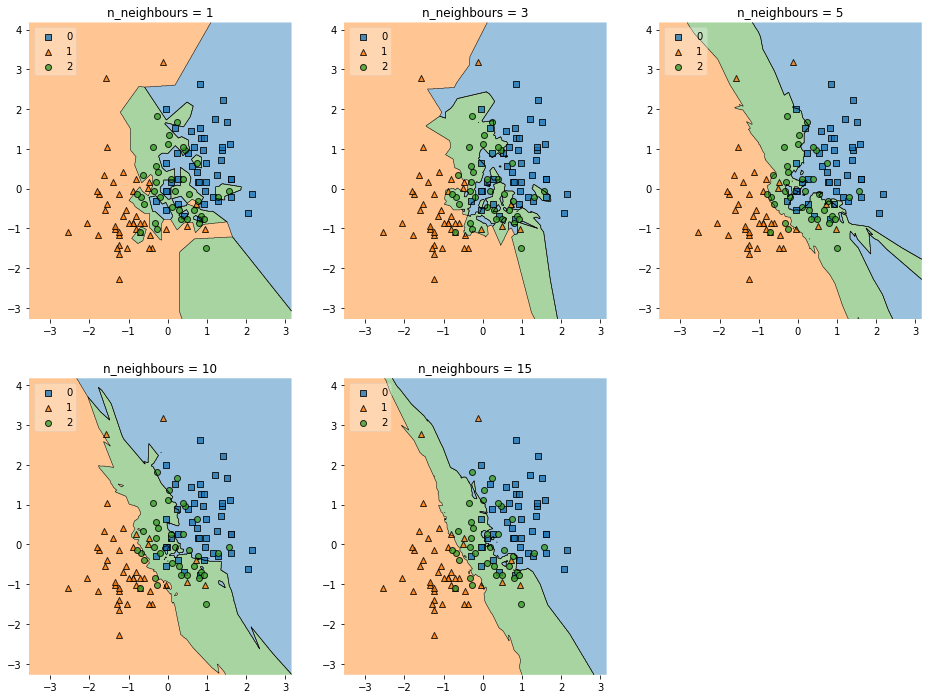

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

# 2, 3 - количество строк и столбцов
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(16,12))

labels = ["n_neighbours = 1", "n_neighbours = 3", "n_neighbours = 5", "n_neighbours = 10", "n_neighbours = 15", "n_neighbours = 25"]
for clf, lab, grd in zip(clfs,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
#     itertools.product([0, 1, 2], repeat=2) -  аналог вложенного цикла
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.asarray(X_train_sc), y=np.asarray(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

Таким образом, оптимальнее всего использовать число соседей от 5 до 10, так как при k = 1 и k = 3 модель явно переобучается, а при k = 10 и k = 15 большое количество синих точек попадает в зелёный класс.

### Обученная машина.

Рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Поместим робота на дискретную двумерную плоскость, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. Пусть на плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Изобразим возможное положение робота и меток.

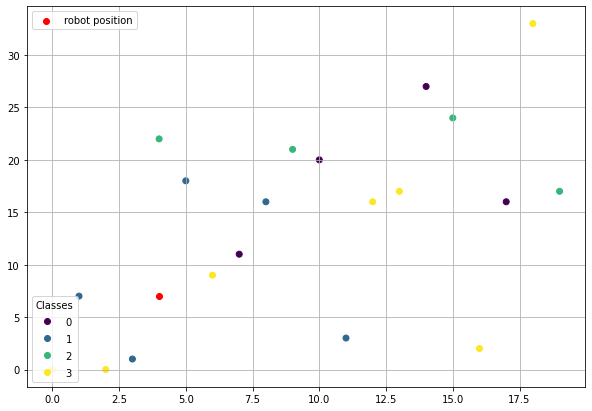

In [13]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

Реализуем класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определим атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определим метод `move()`: рассчитаем новое положение робота по правилам выше и добавим её в историю перемещений. Исходы интерпретируем как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания используем `np.random.binomial()`. 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        # Store the history of movements
        self.trajectory = np.asarray(initial_position).reshape((1,2))
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k, )
        self.knn.fit(landmarks, classes)
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''
        
        if (np.random.binomial(1, 0.2) == 1):
            self.trajectory = np.append(self.trajectory, (self.trajectory[-1] + \
                                                          self.mapping[0]).reshape(1, 2), axis=0)
        else:
            self.trajectory = np.append(self.trajectory, (self.trajectory[-1] + self.mapping[self.knn.predict \
                                              (self.trajectory[-1].reshape(1, -1))[0]]).reshape((1,2)), axis=0)

Дополним функцию `conduct_experiment`: определим переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [16]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = robot.trajectory
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

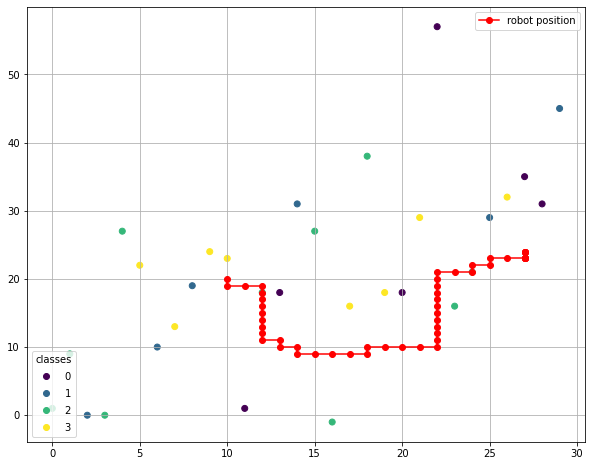

In [17]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

Выясним, как число соседей влияет на траекторию движения робота в нашем эксперименте. Построим четыре графика с различным числом соседей.

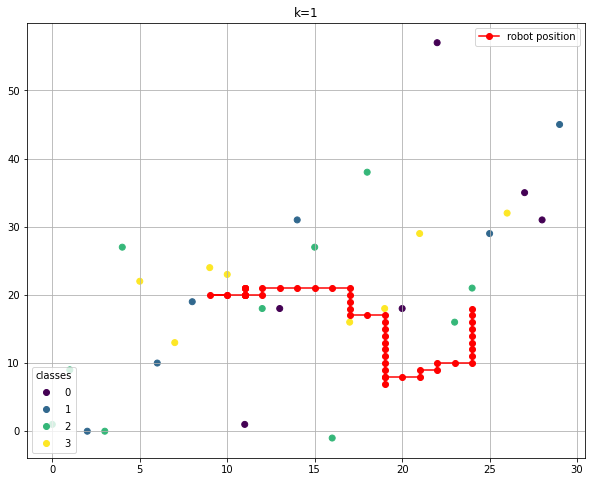

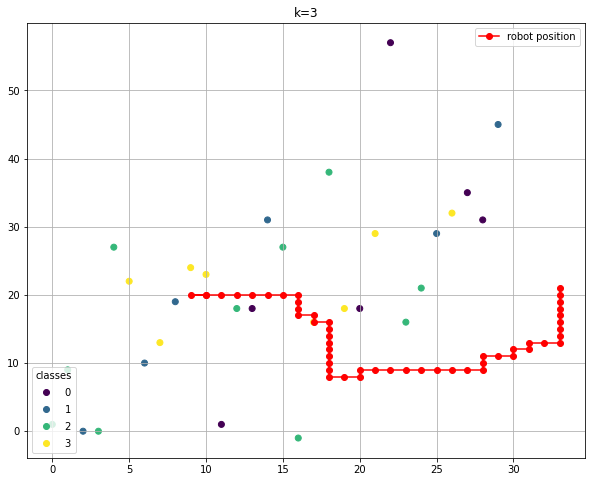

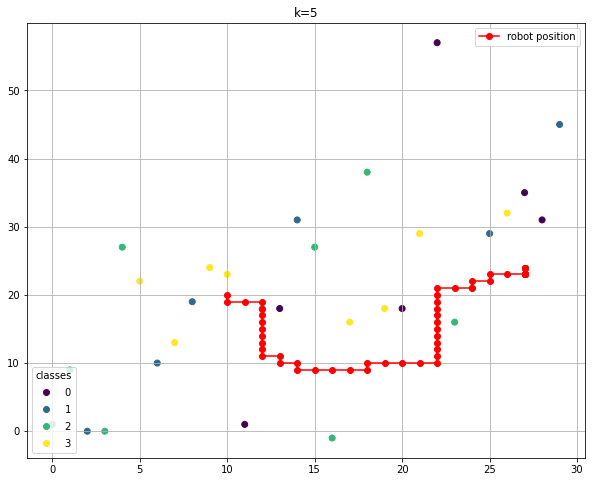

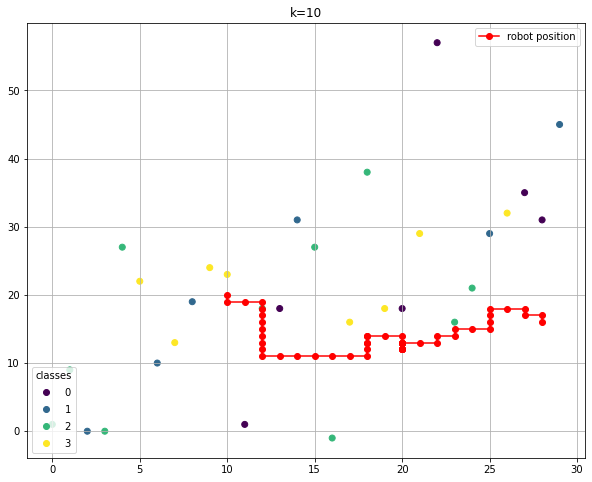

In [18]:
k = [1, 3, 5, 10]
x = np.arange(30)
for i in range(4):
    conduct_experiment(x, mean = 3, std = 10, k = k[i], n_movements = 50)
    title = "k=" + str(k[i])
    plt.title(title)
#Число соседей влияет на желание робота поехать в ту или иную сторону
#Задавая классы меткам осмысленно, можно запрограммировать робота

### Линейная регрессия. Задача предсказания цены бриллианта по его характеристикам.

Рассмотрим различные аспекты построения линейной модели, работая с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [19]:
data = pd.read_csv('data/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Определим, есть ли в наборе данных пропущенные значения.

In [20]:
data.isnull().values.any()

False

Пропущенных значений нет.

Выясним, есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации). 
Удалим их.

In [21]:
data = data.drop("Unnamed: 0", axis=1)

Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для этого потребуются выборочные корреляции между признаками. Выведем матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Определим, какие вещественные признаки коррелируют с целевой переменной больше всего.

<AxesSubplot:>

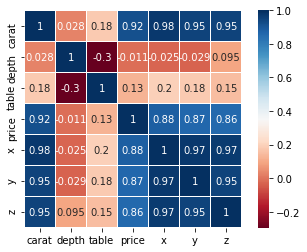

In [22]:
import seaborn as sns

sns.heatmap(data.corr(),
            linewidths=0.1, vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
#Коррелируют размер (x,y,z) и масса камня (carat) 
#Однако xyz и carat тоже коррелируют

Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируем категориальные переменные при помощи OneHot-кодирования.

In [23]:
data = pd.get_dummies(data=data, columns=["cut", "color", "clarity"])

Разделим выборку на тренировочную и тестовую. Долю тестовой выборки укажем равной 0.3.

In [24]:
X = data.drop("price", axis=1)
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. Масштабируем вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [25]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_sc = scaler.transform(X_train)
# X_test_sc = scaler.transform(X_test)

# не работает, так как масштабируются и категориальные признаки (one-hot), а это неправильно

In [26]:
def scale_df(df, sc):
    df_real = df.loc[:, 'carat':'z']
    df_realscaled = pd.DataFrame(sc.transform(df_real), index=df_real.index,
                                 columns=df_real.columns)
    return pd.concat([df_realscaled, df.loc[:, 'cut_Fair':]], axis=1)

In [27]:
scaler = StandardScaler()
train_df = X_train.loc[:, 'carat':'z']
scaler.fit(train_df)
X_train_sc = scale_df(X_train, scaler)
X_test_sc = scale_df(X_test, scaler)

Оценим линейную регрессию на тренировочной выборке. Выведем среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print(f"Train MSE:{mean_squared_error(y_train, lr.predict(X_train_sc))}")
print(f"Test MSE:{mean_squared_error(y_test, lr.predict(X_test_sc))}")
print(f"Train score:{lr.score(X_train_sc, y_train)}")
print(f"Test score:{lr.score(X_test_sc, y_test)}")

Train MSE:1268454.955961559
Test MSE:1303126.748846737
Train score:0.9192711265004452
Test score:0.9204707243216981


Выведем полученные оценки коэффициентов. Найдём вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [29]:
lr.coef_

array([ 5268.33484547,   -73.1113    ,   -67.58876012,  -959.00197931,
          80.66323539,  -238.038613  ,  -608.9842503 ,    16.66815822,
         251.84164281,   184.84981128,   155.624638  ,   810.16549896,
         605.84772546,   541.91097169,   342.24450789,  -158.78346849,
        -632.33579255, -1509.04944296, -3847.02419567,  1519.24204362,
        -143.27826691, -1102.45932839,   776.42704839,   460.5320942 ,
        1199.41410651,  1137.14649826])

In [30]:
pd.DataFrame(np.abs(lr.coef_), index=X_train.columns, columns=['Вес'])
# коэффициенты carat, x 

,Вес
carat,5268.334845
depth,73.111300
table,67.588760
x,959.001979
y,80.663235
z,238.038613
cut_Fair,608.984250
cut_Good,16.668158
cut_Ideal,251.841643
cut_Premium,184.849811


Как можно заметить из анализа корреляционной матрицы, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Воспользуемся вторым вариантом. 

Смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучим Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используем модули `Lasso` и `Ridge` из `sklearn`. Сделаем вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [31]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=10.0)
ridge = Ridge(alpha=10.0)

lasso.fit(X_train_sc, y_train)
ridge.fit(X_train_sc, y_train)

Ridge(alpha=10.0)

In [32]:
pd.DataFrame(np.abs(lasso.coef_), index=X_train.columns, columns=['Вес'])

,Вес
carat,4814.636470
depth,89.051065
table,86.452553
x,528.087185
y,0.000000
z,208.755319
cut_Fair,468.794961
cut_Good,22.120114
cut_Ideal,80.990350
cut_Premium,0.000000


In [33]:
pd.DataFrame(np.abs(ridge.coef_), index=X_train.columns, columns=['Вес'])

,Вес
carat,5231.425555
depth,71.206190
table,67.924148
x,908.559529
y,72.258006
z,246.849416
cut_Fair,611.515282
cut_Good,16.692780
cut_Ideal,252.955318
cut_Premium,184.574110


In [34]:
# Веса уменьшаются незначительно (причём для Лассо - сильнее)
# Проблема мультиколлениарности сильно проявлялась в изначальной регрессии, так как
# веса некоторых признаков занулились

Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляризации $\alpha$: 0.1, 1, 10, 100, 200 –  обучим Lasso- и Ridge-регрессии и построим график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Выясним, какой метод агрессивнее уменьшает веса и почему Lasso-регрессию часто используют для отбора признаков.

/Users/maria/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71795112.58229828, tolerance: 59327375.88300501
  model = cd_fast.enet_coordinate_descent(


,Ridge,Lasso
0.1,7433.377863,7596.983312
1.0,7425.684604,7554.346206
10.0,7350.349783,6620.390568
100.0,6720.671234,3656.669508
200.0,6195.797636,3452.239911


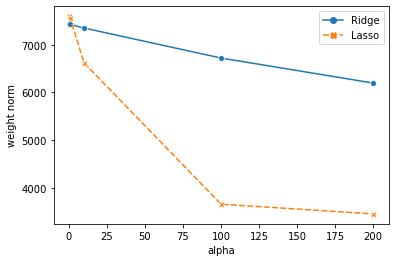

In [35]:
alphas = [0.1, 1, 10, 100, 200]
ridge_norm = []
lasso_norm = []

for a in alphas:
    ridge_i = Ridge(alpha=a)
    ridge_i.fit(X_train_sc, y_train)
    lasso_i = Lasso(alpha=a)
    lasso_i.fit(X_train_sc, y_train)
    ridge_norm.append(np.linalg.norm(ridge_i.coef_))
    lasso_norm.append(np.linalg.norm(lasso_i.coef_))
    
    
df = pd.DataFrame({"Ridge": ridge_norm, "Lasso": lasso_norm}, index=alphas)
fig = sns.lineplot(data=df, markers=True)
fig.set(xlabel='alpha', ylabel='weight norm')
df

In [36]:
# lasso агрессивнее уменьшает веса, поэтому признаки, мало влияющие на ответ, зануляются. Таким образом можно 
# отобрать важные признаки

В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Усредним ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберем то значение, которое даёт наибольшее качество. 

In [47]:
from sklearn.linear_model import LassoCV

alphas = [0.1, 1, 10, 100, 200]
lassocv = LassoCV(alphas=alphas, cv=5, max_iter=3000)
lassocv.fit(X_train_sc, y_train)
lassocv.mse_path_
opt_a = lassocv.alphas_[np.argmin(np.mean(lassocv.mse_path_, axis=1))]
pd.DataFrame(np.mean(lassocv.mse_path_, axis=1), index=lassocv.alphas_, columns=['MSE'])
# наименьшее MSE при альфа = 1

,MSE
200.0,2.413830e+06
100.0,2.197445e+06
10.0,1.308720e+06
1.0,1.272685e+06
0.1,1.272762e+06


Обучим итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведем полученные коэффициенты и определим, какие признаки оказались неинформативными, а какие – наиболее информативными.

In [48]:
lasso = Lasso(alpha=1.0)

lasso.fit(X_train_sc, y_train)

pd.DataFrame(np.abs(lasso.coef_), index=X_train.columns, columns=['Вес'])

,Вес
carat,5230.224086
depth,80.437885
table,69.595007
x,890.187789
y,0.000000
z,195.556188
cut_Fair,740.894205
cut_Good,129.537013
cut_Ideal,91.766757
cut_Premium,19.509804


In [49]:
X_test.columns[lasso.coef_ == 0]
#  неинформативными оказались признаки color_G, cut_Very Good, y

Index(['y', 'cut_Very Good', 'color_G'], dtype='object')

In [53]:
X_test.columns[np.abs(lasso.coef_) > 3000]
#  наиболее информативными оказались признаки carat, clarity_I1

Index(['carat', 'clarity_I1'], dtype='object')

In [ ]:
# В выборке была большая корреляция между carat, y, x. У одинаковых по массе камней 
# одинаковые размеры в ширину. cut_Very Good и cut_Good  стоят примерно одинаково, такая же ситуация с color_G.

Сделаем предсказания обученной Lasso-регрессии на тестовой выборке и сравним среднеквадратичную ошибку с ошибкой обычной линейной регрессии. Определим, какую модель лучше использовать для предсказаний.

In [54]:
print("MSE\n")
print("LinReg:", mean_squared_error(y_test, lr.predict(X_test_sc)),
      "\nLasso:", mean_squared_error(y_test, lasso.predict(X_test_sc)))

MSE

LinReg: 1303126.748846737 
Lasso: 1301366.3660939792


In [ ]:
# Лучше использовать lasso. Значение MSE на ней ниже, так как исчезла проблема мультиколлинеарности признаков 
# (они занулились)